This code was taken directly from the Python script within the "Random Forest" folder of this project. It was not written with a jupyter notebook in mind, but seems to run okay in this environment.

This script is used to create a random forest model, training days of observed flash flood to several kinematic and thermodynamic variables as forecasted by the NAM BUFR sounding during daylight hours. 

First, we will import a number of common modules

In [1]:
%matplotlib inline
import sys
import glob
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score as kappa
import sklearn.ensemble as ens
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
import pickle
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.model_selection import RandomizedSearchCV

Now, set some basic parameters, e.g. the years that are available to us in the csv spreadsheet, the sites we will use, the parameters available in the CSV, etc.

In [2]:
availableYears = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

sites = ["K4HV","KBCE","KPGA","KSGU"]

THERMO = ['MUCAPE', 'DCAPE', '7-5LR', 'LCL','PW', 'MeanRH','DD', 'WC', 'SfcTd', 'SfcT']

KIN = ['0-6km Shear Dir', '0-6km Shear Mag', 'C Dn Dir',
       'C Dn Mag', 'C Up Dir', 'C Up Mag', 'SM Dir','SM Mag',
       'MW Dir','MW Mag', '4-6km dir',
       '4-6km mag']

# If a random split is used, different percentages for the testing portion can be used
# Currently, both 'drier' and 'wetter' sites are set to use the same % for testing
drySites = ["K4HV","KSGU"]
drySitesPercentage = 30
wetSitesPercentage = 30
# Default to the wetter sites percentage
percentToTest = wetSitesPercentage

This section sets the various options for the output random forest model. It was designed to be run from a command line, hence the prompts. The prompts still seem to work in this environment, so they have been left as is.

This has been designed so the most commonly used options are the defaults, and they can be achieved by hitting the Enter key. So, basically just hit the enter key a number of times to advance through the prompts.

In [3]:
response = input("Select a method to divide the training data. \n" + \
                 "    Enter '1' for random, '2' or just <enter> for specific years: ")
print('\n')

if len(response) == 0 or response == '2':
   response2 = input("Enter years for training, either comma separated for each year or a range divided by a dash. \n" +
               "    Default is '2011-2015' for training, or just <enter>: ")
   print('\n')
   if ',' in response2:
      trainingYearsList = list(map(int, response2.split(",")))
   elif '-' in response2:
      firstYear = datetime.strptime(str(response2[0:response2.find('-')]),'%Y')
      secondYear = datetime.strptime(str(response2[response2.find('-')+1:len(response2)]),'%Y')
      trainingYearsList = range(firstYear.year, secondYear.year+1)
   elif len(response2) == 0:
      trainingYearsList = [2011, 2012, 2013, 2014, 2015]
   else:
      print("please use the format indicated in the prompts")
      sys.exit()   
   testingYearsList = [x for x in availableYears if x not in trainingYearsList]

response3 = input("Run on each subdivided group of basins (e.g. KSGU) or all at once (KBCE only)?\n" + \
                  "   If running on all at once, you will have the option to run the program iteratively\n" + \
		  "   to obtain a desired skill level.\n" + \
                  "   Enter '1' to see the results for each basin, '2' or just <enter> for all in one:\n ") 
print('\n')

response4 = input("Select a model for the BUFR sounding. \n" + \
                  "   Enter '1' for RAP, '2' or just <enter> for NAM: ")
print('\n')

response5 = input("Display reliability plot of # of flooding vs probabilistic output? \n" + \
                  "   Enter '1' for no, '2' or just <enter> for yes: ")
print('\n')

response6 = input("Calculate stats for RRA and blended RRA/RandomForest? \n" + \
                  "   Enter '1' for no, '2' or just <enter> for yes: ")
print('\n')

response7 = input("Run multiple times (iteratively) to reach a target accuracy? \n" + \
                  "   Enter '1' for yes, '2' or just <enter> for no: ")
print('\n')

if response7 == '1':
    response8 = input("Target metric for an 'accurate' forecast: \n" + \
                      "   Enter '1' for Cohen's Kappa (deterministic), '2' or just <enter> for Brier (probabilistic): ")
    print('\n')
    
    if response8 == '1':
        response9 = input("Target Cohen's Kappa: \n" + \
                          "   E.g, 0.35: ")
        print('\n')
    else:
        response9 = input("Target Brier Score: \n" + \
                          "   E.g, 0.07: ")
        print('\n') 		      			  

response10 = input("Save the Random Forest Model for the RRA tool? \n" + \
                  "   Enter '1' for yes, '2' or just <enter> for no: ")
print('\n') 

response11 = input("Search for optimal hyperparameters (increases runtime)? \n" + \
                  "   Enter '1' for yes, '2' or just <enter> for no: ")
print('\n')

Select a method to divide the training data. 
    Enter '1' for random, '2' or just <enter> for specific years: 


Enter years for training, either comma separated for each year or a range divided by a dash. 
    Default is '2011-2015' for training, or just <enter>: 


Run on each subdivided group of basins (e.g. KSGU) or all at once (KBCE only)?
   If running on all at once, you will have the option to run the program iteratively
   to obtain a desired skill level.
   Enter '1' to see the results for each basin, '2' or just <enter> for all in one:
 


Select a model for the BUFR sounding. 
   Enter '1' for RAP, '2' or just <enter> for NAM: 


Display reliability plot of # of flooding vs probabilistic output? 
   Enter '1' for no, '2' or just <enter> for yes: 


Calculate stats for RRA and blended RRA/RandomForest? 
   Enter '1' for no, '2' or just <enter> for yes: 


Run multiple times (iteratively) to reach a target accuracy? 
   Enter '1' for yes, '2' or just <enter> for no: 


Save

This optional subroutine handles the creation of reliability plots.

In [4]:
def createReliabilityPlots(response5, response6, ytest, yprob, yprob2, yprob3):
      if response5 == '2' or len(response5) == 0:
         clf_score = brier_score_loss(ytest, yprob)
         fraction_of_positives, mean_predicted_value = calibration_curve(ytest, yprob, n_bins=10)
         plt.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
         plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s (%1.3f)" % ("Random Forest Model", clf_score))
         plt.legend(loc='best')
         # Add plots for legacy RRA product comparison, if requested
         if response6 == '2' or len(response6) == 0:
            clf_score = brier_score_loss(ytest, yprob2)
            plt.figure() 
            fraction_of_positives, mean_predicted_value = calibration_curve(ytest, yprob2, n_bins=10)
            plt.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
            plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s (%1.3f)" % ("Legacy RRA", clf_score))
            plt.legend(loc='best')

            clf_score = brier_score_loss(ytest, yprob3)
            plt.figure() 
            fraction_of_positives, mean_predicted_value = calibration_curve(ytest, yprob3, n_bins=10)
            plt.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
            plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s (%1.3f)" % ("Blended RRA & Random Forest", clf_score))
            plt.legend(loc='best')

The optional subroutine handles tuning of hyperparameters.

In [5]:
def tuneHyperparameters(xtrain, ytrain):
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 20000, num = 10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
		   'max_depth': max_depth,
		   'min_samples_split': min_samples_split,
		   'min_samples_leaf': min_samples_leaf,
		   'bootstrap': bootstrap}
    clf = ens.RandomForestClassifier()
    clfRandom = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100,
                                   cv = 3, random_state = 42, n_jobs = -1)
    clfRandom.fit(xtrain, ytrain)
    print(clfRandom.best_params_)
    return(clfRandom)

Open the appropriate CSV files for the selected model

In [6]:
if len(response4) == 0 or response4 == '2':
   model = "NAM"
else:
   model = "RAP"

if model == "NAM":
   fileString = 'csv/*.csv'
elif model == "RAP":
   fileString = 'csv/*full_clean.csv'

This is where the bulk of the work is done. Loop through each CSV, find whether it matches the site of choice, then run the random forest creation.




FFW model results for KBCE using the NAM, testing on [2016, 2017, 2018]
Probabilistic Verification
Brier Score 0.06, AUC = 0.89 
Deterministic Verification
Accuracy = 0.91, Cohen's Kappa 0.26
                      No Flooding Forecast  Flooding Forecast
No Flooding Observed                   440                 17
Flooding Observed                       28                 10

SLC RRA verification for KBCE using the NAM, testing on [2016, 2017, 2018]
Probabilistic Verification
Brier Score 0.09, AUC = 0.80 
Deterministic Verification
Accuracy = 0.91, Cohen's Kappa 0.39
                      No Flooding Forecast  Flooding Forecast
No Flooding Observed                   434                 23
Flooding Observed                       21                 17

SLC combined verification for KBCE using the NAM, testing on [2016, 2017, 2018]
Probabilistic Verification
Brier Score 0.07, AUC = 0.89 
Deterministic Verification
Accuracy = 0.92, Cohen's Kappa 0.38
                      No Flooding Fo

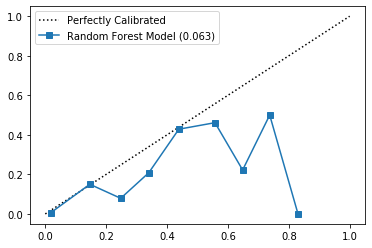

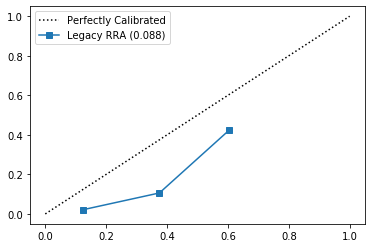

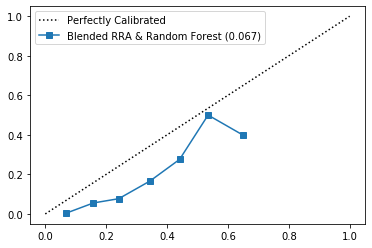

In [7]:
for csv in glob.glob(fileString):
   
   probabilisticOutput = []
   deterministicOutput = []

   # Find the site name and fix if necessary
   if model == "NAM":
      site = csv[-8:-4]
   elif model == "RAP":
      site = csv[-19:-15]
   if site == '/4HV':
      site = 'K4HV'
   elif site == '4HV_':
      site = 'K4HV'

   # Only use the KBCE site if that's what was requested     
   if response3 == '2' or len(response3) == 0:
      if site != 'KBCE':
         continue

   # loop as needed to reach target metrics
   targetAccuracy = False   
   while not targetAccuracy:

      if site in drySites:
         percentToTest = drySitesPercentage
      else:
         percentToTest = wetSitesPercentage

      df = pd.read_csv(csv)
      
      # This was in Nick's code. It calls three basins flooding a flash flood day for KBCE (all), and 1 basin
      # a hit for 4HV/SGU
      if site == 'KBCE':
         df.loc[(df['Basins'] == 3), 'Result'] = 1
      if '4HV' or 'SGU' in site_name:
         df.loc[(df['Basins'] == 1), 'Result'] = 1
            
      # Make a new dataframe that removes any dates with missing entries, set up the predictor & predictands   
      df2 = df.dropna(subset=KIN + THERMO + ['Basins'] + ['Result'] + ['deterministicRRA'] + ['probabilisticRRA'])  
      result = df2['Result']
      predictors = df2[THERMO + KIN]

      # Random split of dates option, otherwise use fixed dates
      if response == '1': 
         xtrain, xtest, ytrain, ytest = train_test_split(predictors, result, test_size = percentToTest/100)
         test_df = df.iloc[xtest.index.tolist()]
      elif len(response) == 0 or response == '2':
         # Slightly convoluted way to use the years the user specifies
         training_df = df2
         test_df = df2
         for year in testingYearsList:
            training_df = training_df[training_df['Year'] != year]
         for year in trainingYearsList:
            test_df = test_df[test_df['Year'] != year] 	  
         xtrain = training_df[THERMO + KIN]
         xtest = test_df[THERMO + KIN]
         ytrain = training_df.pop('Result')
         ytest = test_df.pop('Result')

      # Create a random forest model using a default set of hyperparameters. If the user specifies, 
      # tune the hyperparameters first
      if len(response11) == 0 or response11 == '2':
         clf = ens.RandomForestClassifier(n_estimators=2400, max_depth=30, min_samples_leaf=1,
                                      	min_samples_split=5,oob_score=True,
                                	class_weight='balanced')
         clf.fit(xtrain, ytrain)					
      else:
         clf = tuneHyperparameters(xtrain, ytrain)			     

      # Run the model on the data, and collect a number of verification metrics      
      y_pred = clf.predict(xtest)
      accuracy = metrics.accuracy_score(ytest, y_pred)
      yprob = clf.predict_proba(xtest)[0:, 1]
      #yprob = (yprob+yprob2)/2
      brier_score = metrics.brier_score_loss(ytest, yprob)
      auc = metrics.roc_auc_score(ytest, yprob)
      cm = metrics.confusion_matrix(ytest, y_pred)
      index_names = ['No Flooding Observed', 'Flooding Observed']
      col_names = ['No Flooding Forecast', 'Flooding Forecast']
      cm_df = pd.DataFrame(cm, columns =col_names, index=index_names)
      ck = kappa(ytest, y_pred)
      print('\n\n')
      if 'trainingYearsList' in locals():
         print('FFW model results for ' + site + ' using the ' + model + ', testing on ' + str(testingYearsList))
      else:
         print('FFW model results for ' + site + ' using the ' + model + ', testing on ' + str(percentToTest) + '% of the 2011-2018 dataset')
      print('Probabilistic Verification')
      print('Brier Score {:3.2f}, '.format(brier_score) +
             'AUC = {:3.2f} '.format(auc))
      print('Deterministic Verification')
      print('Accuracy = {:3.2f}, '.format(accuracy) +
              'Cohen\'s Kappa {:3.2f}'.format(ck))
      print(cm_df.head())

      # If desired, run stats for the legacy RRA product and a blend of the RRA and the random forest model
      if response6 == '2' or len(response6) == 0:
         # Stats for RRA
         yprob2 = test_df['probabilisticRRA']
         y_pred2 = test_df['deterministicRRA']
         auc = metrics.roc_auc_score(ytest, yprob2)
         brier_score = metrics.brier_score_loss(ytest, yprob2)
         accuracy = metrics.accuracy_score(ytest, y_pred2)
         cm = metrics.confusion_matrix(ytest, y_pred2)   
         cm_df = pd.DataFrame(cm, columns =col_names, index=index_names)
         ck = kappa(ytest, y_pred2)
         if 'trainingYearsList' in locals():
            print('\nSLC RRA verification for ' + site + ' using the ' + model + ', testing on ' + str(testingYearsList))
         else:
            print('\nSLC RRA verification for ' + site + ' using the ' + model + ', testing on ' + str(percentToTest) + '% of the 2011-2018 dataset')
         print('Probabilistic Verification')
         print('Brier Score {:3.2f}, '.format(brier_score) +
                'AUC = {:3.2f} '.format(auc))
         print('Deterministic Verification')
         print('Accuracy = {:3.2f}, '.format(accuracy) +
                 'Cohen\'s Kappa {:3.2f}'.format(ck))
         print(cm_df.head())

         # Stats for blend of RRA and random forest model
         yprob3 = (test_df['probabilisticRRA'] + yprob)/2
         y_pred3 = round(yprob3)
         auc = metrics.roc_auc_score(ytest, yprob3)
         brier_score = metrics.brier_score_loss(ytest, yprob3)
         accuracy = metrics.accuracy_score(ytest, y_pred3)
         cm = metrics.confusion_matrix(ytest, y_pred3)   
         cm_df = pd.DataFrame(cm, columns =col_names, index=index_names)
         ck = kappa(ytest, y_pred3)
         if 'trainingYearsList' in locals():   
            print('\nSLC combined verification for ' + site + ' using the ' + model + ', testing on ' + str(testingYearsList))
         else:
            print('\nSLC combined verification for ' + site + ', testing on ' + str(percentToTest) + '% of the 2011-2018 dataset')
         print('Probabilistic Verification')
         print('Brier Score {:3.2f}, '.format(brier_score) +
        	'AUC = {:3.2f} '.format(auc))
         print('Deterministic Verification')
         print('Accuracy = {:3.2f}, '.format(accuracy) +
        	 'Cohen\'s Kappa {:3.2f}'.format(ck))
         print(cm_df.head())

      print('\n\n')

      # This section handles the target accuracy requirements, if selected
      # When the accuracy targets are reached, plots may be created and the model may be saved to a pickle file  
      if response7 != '1':
         targetAccuracy = True
         createReliabilityPlots(response5, response6, ytest, yprob, yprob2, yprob3)
         if response10 == '1':
            pickle.dump(clf, open(saveFile, 'wb'))	 	 
      else:
         if response8 == '1':
            if ck > float(response9):
               targetAccuracy = True
               createReliabilityPlots(response5, response6, ytest, yprob, yprob2, yprob3)
               if response10 == '1':
                   pickle.dump(clf, open(saveFile, 'wb'))
            else:
               print("Didn't reach target Cohen's Kappa of "+str(response9)+", only reached "+str(ck)+", trying again")	
         else:
            if brier_score < float(response9):
               targetAccuracy = True
               createReliabilityPlots(response5, response6, ytest, yprob, yprob2, yprob3)
               if response10 == '1':
                   pickle.dump(clf, open(saveFile, 'wb'))	       
            else:
               print("Didn't reach target Brier Skill Score of "+str(response9)+", only reached "+str(brier_score)+", trying again")          
            